# Overview of the Notebook
This notebook generates the test data and then evaluiate the models trained with different hyperparameters on this test data and visualizes the different results. Also, this script does an ablation study for different configurations the models have been trained on.

In [29]:
import cv2
import torch
import json
import numpy as np
import torch.nn as nn
from pathlib import Path
import albumentations as A
import matplotlib.pyplot as plt
import torchvision.models.video as video_models
from torch.utils.data import Dataset, DataLoader
import os
import random
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import shutil
from datetime import datetime

# Generating test data

In [32]:
SOURCE_DIR = r'/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/data/9-classes'
TARGET_DIR = r'/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/data/test9-classes'
NUM_VIDEOS_PER_CLASS = 20
RANDOM_SEED = 42

# Setting random seed for reproducibility
random.seed(RANDOM_SEED)

# Creating target directory if it doesn't exist
os.makedirs(TARGET_DIR, exist_ok=True)

# Getting all class folders
class_folders = [f for f in os.listdir(SOURCE_DIR) 
                 if os.path.isdir(os.path.join(SOURCE_DIR, f))]

print(f"Found {len(class_folders)} class folders.")

# Processing each class folder
for class_folder in tqdm(class_folders, desc="Processing classes"):
    source_class_path = os.path.join(SOURCE_DIR, class_folder)
    target_class_path = os.path.join(TARGET_DIR, class_folder)
    
    # Creating class folder in target directory
    os.makedirs(target_class_path, exist_ok=True)
    
    # Getting all video files
    video_files = [f for f in os.listdir(source_class_path) 
                  if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    
    # Checking if we have enough videos
    if len(video_files) <= NUM_VIDEOS_PER_CLASS:
        print(f"Warning: Class {class_folder} has only {len(video_files)} videos, "
              f"using all of them.")
        selected_videos = video_files
    else:
        selected_videos = random.sample(video_files, NUM_VIDEOS_PER_CLASS)
    
    for video in selected_videos:
        source_file = os.path.join(source_class_path, video)
        target_file = os.path.join(target_class_path, video)
        shutil.copy2(source_file, target_file)
    
    print(f"  - {class_folder}: Copied {len(selected_videos)} videos")

total_videos = sum(len(os.listdir(os.path.join(TARGET_DIR, class_folder))) 
                   for class_folder in class_folders)

print(f"\nTest set creation complete!")
print(f"Created test set with {total_videos} videos across {len(class_folders)} classes.")
print(f"Test set location: {TARGET_DIR}")

Found 9 class folders.


Processing classes:  22%|██▏       | 2/9 [00:00<00:01,  5.51it/s]

  - Yellow card: Copied 20 videos
  - Corner: Copied 20 videos


Processing classes:  44%|████▍     | 4/9 [00:00<00:00,  6.92it/s]

  - Penalty: Copied 2 videos
  - Foul: Copied 20 videos


Processing classes:  67%|██████▋   | 6/9 [00:00<00:00,  6.68it/s]

  - Red card: Copied 4 videos
  - Shots off target: Copied 20 videos


Processing classes:  89%|████████▉ | 8/9 [00:01<00:00,  6.16it/s]

  - Shots on target: Copied 20 videos
  - Kick-off: Copied 20 videos


Processing classes: 100%|██████████| 9/9 [00:01<00:00,  5.95it/s]

  - Goal: Copied 20 videos

Test set creation complete!
Created test set with 146 videos across 9 classes.
Test set location: /Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/data/test9-classes


# Getting the video paths along with labels

In [40]:
def load_video_paths(data_root):
    video_paths = []
    labels = []
    class_names = sorted(os.listdir(data_root))
    label_to_idx = {name: i for i, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = Path(data_root) / class_name
        for video_file in class_dir.glob("*.mp4"):
            video_paths.append(str(video_file))
            labels.append(label_to_idx[class_name])
    return video_paths, labels, label_to_idx

video_paths, labels, label_to_idx = load_video_paths(r'/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/data/test9-classes')
idx_to_label = {v: k for k, v in label_to_idx.items()}

In [41]:
class SoccerDataset(Dataset):
    def __init__(self, video_paths, labels, config):
        self.video_paths = video_paths
        self.labels = labels
        self.config = config
        self.transform = A.Compose([
            A.Resize(height=config['frame_height'], width=config['frame_width']),
            A.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989])
        ])

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        path = self.video_paths[idx]
        label = self.labels[idx]
        frames = self._load_video(path)
        return frames, label

    def _load_video(self, path):
        cap = cv2.VideoCapture(path)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        indices = np.linspace(0, frame_count - 1, self.config['num_frames'], dtype=int)
        frames = []
 
        for i in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                continue
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = self.transform(image=frame)['image']
            frames.append(frame)
 
        cap.release()
 
        frames = np.array(frames)
        frames = np.transpose(frames, (3, 0, 1, 2))
        return torch.from_numpy(frames).float()


# Model architecture

In [42]:
class R3DClassifier(nn.Module):
    def __init__(self, num_classes, config):
        super(R3DClassifier, self).__init__()

        model_type = config['model_type'].lower()
        pretrained = config['pretrained']
        dropout = config['dropout']

        if model_type == 'r3d':
            self.model = video_models.r3d_18(pretrained=pretrained)
        elif model_type == 'mc3':
            self.model = video_models.mc3_18(pretrained=pretrained)
        elif model_type == 'r2plus1d':
            self.model = video_models.r2plus1d_18(pretrained=pretrained)
        else:
            raise ValueError(f"Unsupported model_type '{model_type}' in CONFIG")

        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)


# Evaluating the model

In [43]:
def evaluate_model(model_path, config, video_paths, labels, idx_to_label):
    # Creating test dataset and dataloader
    test_loader = DataLoader(SoccerDataset(video_paths, labels, config), batch_size=config['batch_size'], shuffle=True)
    
    # Initializing and loading model we need to evaluate
    model = R3DClassifier(num_classes=len(idx_to_label), config=config).to(config['device'])
    model.load_state_dict(torch.load(model_path, map_location=config['device']))
    model.eval()
    
    # To store model results
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for videos, batch_labels in tqdm(test_loader, desc="Evaluating"):
            videos, batch_labels = videos.to(config['device']), batch_labels.to(config['device'])
            outputs = model(videos)
            probs = torch.softmax(outputs, dim=1)
            
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            all_targets.extend(batch_labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_targets, all_preds)
    conf_matrix = confusion_matrix(all_targets, all_preds)
    class_report = classification_report(all_targets, all_preds, 
                                         target_names=[idx_to_label[i] for i in range(len(idx_to_label))], 
                                         output_dict=True)
    
    # Return results
    return {
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'predictions': all_preds,
        'targets': all_targets,
        'probabilities': all_probs
    }

# Visualizing the results

In [44]:
def visualize_results(results, idx_to_label, config_name, save_dir="results"):
    os.makedirs(save_dir, exist_ok=True)
    
    # Confusion Matrix
    plt.figure(figsize=(12, 10))
    labels = [idx_to_label[i] for i in range(len(idx_to_label))]
    conf_matrix = results['confusion_matrix']
    
    # Normalize confusion matrix
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(f'Normalized Confusion Matrix - {config_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{config_name}_confusion_matrix.png'), dpi=300)
    plt.close()
    
    # Class-wise performance
    class_report = results['classification_report']
    print(class_report)
    df = pd.DataFrame(class_report).transpose()
    
    # Filter out the avg/total rows
    df = df[~df.index.isin(['accuracy', 'macro avg', 'weighted avg'])]
    
    plt.figure(figsize=(14, 8))
    sns.barplot(x=df.index, y=df['f1-score'])
    plt.title(f'F1-Score by Class - {config_name}')
    plt.ylabel('F1-Score')
    plt.xlabel('Class')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{config_name}_f1_scores.png'), dpi=300)
    plt.close()
    
    # Save full results as JSON
    clean_results = {
        'accuracy': float(results['accuracy'])
    }

    # Safely process classification report
    if isinstance(class_report, dict):
        clean_class_report = {}
        for k, v in class_report.items():
            if isinstance(v, dict):
                clean_class_report[k] = {
                    kk: float(vv) for kk, vv in v.items() 
                    if isinstance(vv, (int, float))
                }
            elif isinstance(v, (int, float)):
                clean_class_report[k] = float(v)
        clean_results['classification_report'] = clean_class_report
    
    with open(os.path.join(save_dir, f'{config_name}_results.json'), 'w') as f:
        json.dump(clean_results, f, indent=4)
    
    return


# Ablation study for models trained on different configurations

In [45]:
def run_ablation_study(configs, model_paths, test_folder, video_paths, labels, idx_to_label, output_dir="ablation_results"):
    # Create output directory with timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_dir = f"{output_dir}_{timestamp}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Change working directory to output directory
    original_dir = os.getcwd()
    os.chdir(output_dir)
    
    # Create results directory
    os.makedirs('results', exist_ok=True)
    
    # Load test data (only need to do this once)
    
    # Results container
    comparative_results = {}
    
    # Evaluate each model
    for i, (config, model_path) in enumerate(zip(configs, model_paths)):
        config_name = f"config_{i+1}"
        print(f"\n{'='*50}\nEvaluating {config_name}: {model_path}\n{'='*50}")
        
        # Evaluate model
        results = evaluate_model(model_path, config, video_paths, labels, idx_to_label)
        
        # Visualize results
        visualize_results(results, idx_to_label, config_name)
        
        # Save to comparative results
        comparative_results[config_name] = {
            'accuracy': float(results['accuracy']),
            'config': {k: str(v) if isinstance(v, torch.device) else v 
                      for k, v in config.items() if k not in ['device']},
            'model_path': model_path
        }
    
    # Create comparative visualization
    configs_df = pd.DataFrame({
        'Configuration': [f"Config {i+1}" for i in range(len(configs))],
        'Accuracy': [comparative_results[f"config_{i+1}"]['accuracy'] for i in range(len(configs))]
    })
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Configuration', y='Accuracy', data=configs_df)
    plt.title('Accuracy Comparison Across Configurations')
    plt.ylim(0, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('results/comparative_accuracy.png', dpi=300)
    plt.close()
    
    # Save comparative results
    with open('results/ablation_study_results.json', 'w') as f:
        json.dump(comparative_results, f, indent=4)
    
    print(f"\nResults saved to {output_dir}")
    os.chdir(original_dir)
    
    return comparative_results


In [ ]:
TEST_FOLDER = r'/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/data/test9-classes'

# Define your configurations as Python dictionaries
CONFIG1 = {
    'frame_height': 224,
    'frame_width': 224,
    'num_frames': 32,
    'batch_size': 4,
    'epochs': 15,
    'learning_rate': 1e-4,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'fold' : 3,
    'optimizer': 'adam',
    'scheduler': 'cosine',
    'dropout': 0.5,
    'model_type': 'r3d',
    'pretrained': True,
}

# Set seed
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

CONFIG2 = {
    'frame_height': 224,
    'frame_width': 224,
    'num_frames': 32,
    'batch_size': 8,
    'epochs': 16,
    'learning_rate': 3e-4,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'fold' : 3,
    'optimizer': 'adam',
    'scheduler': 'cosine',
    'dropout': 0.7,
    'model_type': 'r3d',
    'pretrained': True,
}

CONFIG3 = {
    'frame_height': 232,
    'frame_width': 232,
    'num_frames': 32,
    'batch_size': 4,
    'epochs': 8,
    'learning_rate': 1e-3,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'fold' : 3,
    'optimizer': 'sgd',
    'scheduler': 'cosine',
    'dropout': 0.3,
    'model_type': 'r3d',
    'pretrained': False,
}

CONFIG4 = {
    'frame_height': 224,
    'frame_width': 224,
    'num_frames': 32,
    'batch_size': 8,
    'epochs': 16,
    'learning_rate': 3e-4,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'fold' : 3,
    'optimizer': 'adam',
    'scheduler': 'cosine',
    'dropout': 0.7,
    'model_type': 'r3d',
    'pretrained': False,
}


CONFIG5 = {
    'frame_height': 232,
    'frame_width': 232,
    'num_frames': 16,
    'batch_size': 4,
    'epochs': 5,
    'learning_rate': 1e-3,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'fold' : 3,
    'optimizer': 'sgd',
    'scheduler': 'cosine',
    'dropout': 0.3,
    'model_type': 'r3d',
    'pretrained': True,
}

CONFIG6 = {
    'data_root': '9-classes',
    'frame_height': 232,
    'frame_width': 232,
    'num_frames': 16,
    'batch_size': 4,
    'epochs': 5,
    'learning_rate': 1e-4,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'fold' : 3,
    'optimizer': 'sgd',
    'scheduler': 'cosine',
    'dropout': 0.5,
    'model_type': 'r3d',
    'pretrained': False,
}

# Paths to your saved models (change these to your model paths)
MODEL_PATH1 = r"/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/models/best_model_config1.pth"
MODEL_PATH2 = r"/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/models/best_model_config2.pth"
MODEL_PATH3 = r"/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/models/best_model_config3.pth"
MODEL_PATH4 = r"/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/models/best_model_config4.pth"
MODEL_PATH5 = r"/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/models/best_model_config5.pth"
MODEL_PATH6 = r"/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/models/best_model_config6.pth"

# Run ablation study
results = run_ablation_study(
    configs=[CONFIG1, CONFIG2, CONFIG3, CONFIG4,CONFIG5,CONFIG6],
    model_paths=[MODEL_PATH1, MODEL_PATH2, MODEL_PATH3, MODEL_PATH4, MODEL_PATH5,MODEL_PATH6],
    test_folder=TEST_FOLDER,
    video_paths=video_paths,
    labels=labels,
    idx_to_label=idx_to_label,
    output_dir="ablation_results"
)

# Print summary
print("\n==== ABLATION STUDY RESULTS ====")
for config_name, result in results.items():
    print(f"{config_name}: Accuracy = {result['accuracy']:.4f}")
    print(f"Key Configuration Parameters:")
    for param in ['batch_size', 'learning_rate', 'optimizer', 'dropout', 'pretrained']:
        print(f"  - {param}: {result['config'][param]}")
    print("-" * 40)


Evaluating config_1: /Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/models/best_model_config1.pth


Evaluating: 100%|██████████| 37/37 [14:01<00:00, 22.75s/it]
/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/myenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: 

{'Corner': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 20.0}, 'Foul': {'precision': 1.0, 'recall': 0.9, 'f1-score': 0.9473684210526315, 'support': 20.0}, 'Goal': {'precision': 0.9090909090909091, 'recall': 1.0, 'f1-score': 0.9523809523809523, 'support': 20.0}, 'Kick-off': {'precision': 0.9047619047619048, 'recall': 0.95, 'f1-score': 0.926829268292683, 'support': 20.0}, 'Penalty': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2.0}, 'Red card': {'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'support': 4.0}, 'Shots off target': {'precision': 0.8095238095238095, 'recall': 0.85, 'f1-score': 0.8292682926829268, 'support': 20.0}, 'Shots on target': {'precision': 0.85, 'recall': 0.85, 'f1-score': 0.85, 'support': 20.0}, 'Yellow card': {'precision': 0.9090909090909091, 'recall': 1.0, 'f1-score': 0.9523809523809523, 'support': 20.0}, 'accuracy': 0.910958904109589, 'macro avg': {'precision': 0.8202741702741703, 'recall': 0.7833333333333333, 'f1

/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/myenv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jenishkothari/Northeastern/CS6140/Automatic Highlight Generation/myenv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Evaluating:  21%|██        | 4/19 [18:17<1:07:44, 270.94s/it]

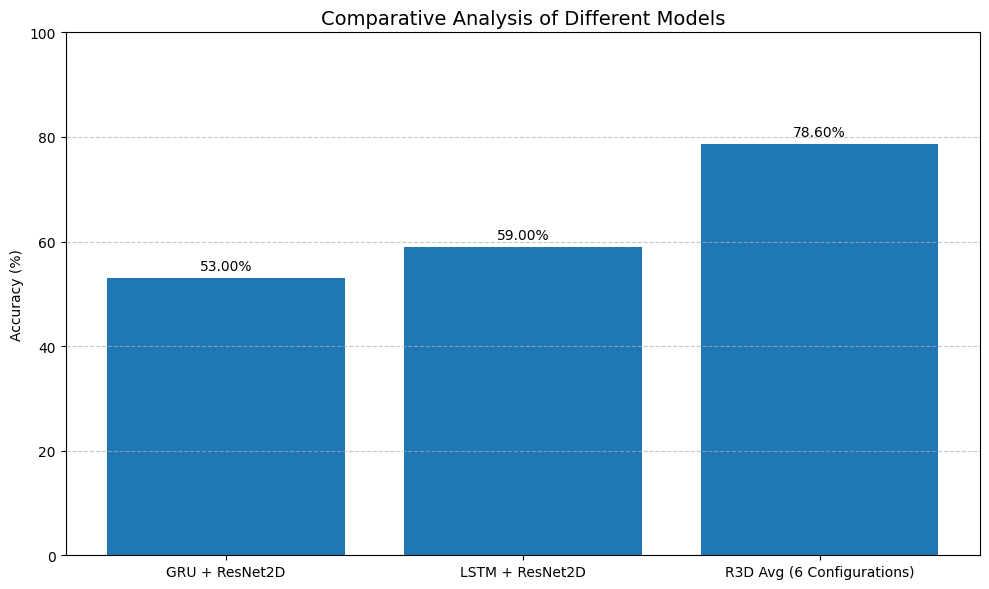

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# R3D Config Accuracies
r3d_data = {
    "config_1": 0.8904109589041096,
    "config_2": 0.910958904109589,
    "config_3": 0.636986301369863,
    "config_4": 0.7054794520547946
}

# Calculate average R3D accuracy
r3d_accuracies = list(r3d_data.values())
avg_r3d = np.mean(r3d_accuracies)

# Other model accuracies
gru_resnet2d = 0.53
lstm_resnet2d = 0.59

# Convert to percentages
gru_percent = gru_resnet2d * 100
lstm_percent = lstm_resnet2d * 100
r3d_percent = avg_r3d * 100

# Labels and values
model_names = ['GRU + ResNet2D', 'LSTM + ResNet2D', 'R3D Avg (6 Configurations)']
accuracies = [gru_percent, lstm_percent, r3d_percent]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies)

# Add value labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10)

# Title and labels
plt.title("Comparative Analysis of Different Models", fontsize=14)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


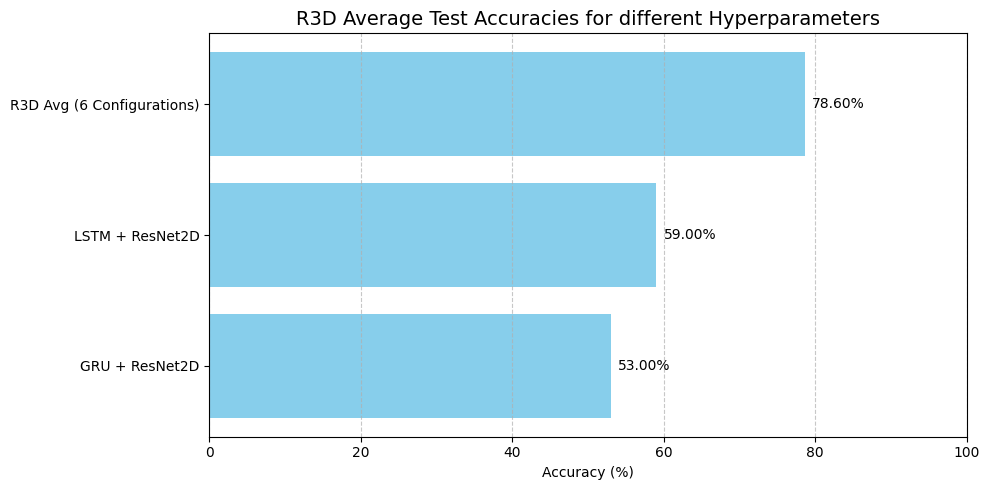

In [6]:
plt.figure(figsize=(10, 5))
bars = plt.barh(model_names, accuracies, color='skyblue')
for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%', va='center')
plt.title("R3D Average Test Accuracies for different Hyperparameters", fontsize=14)
plt.xlabel("Accuracy (%)")
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


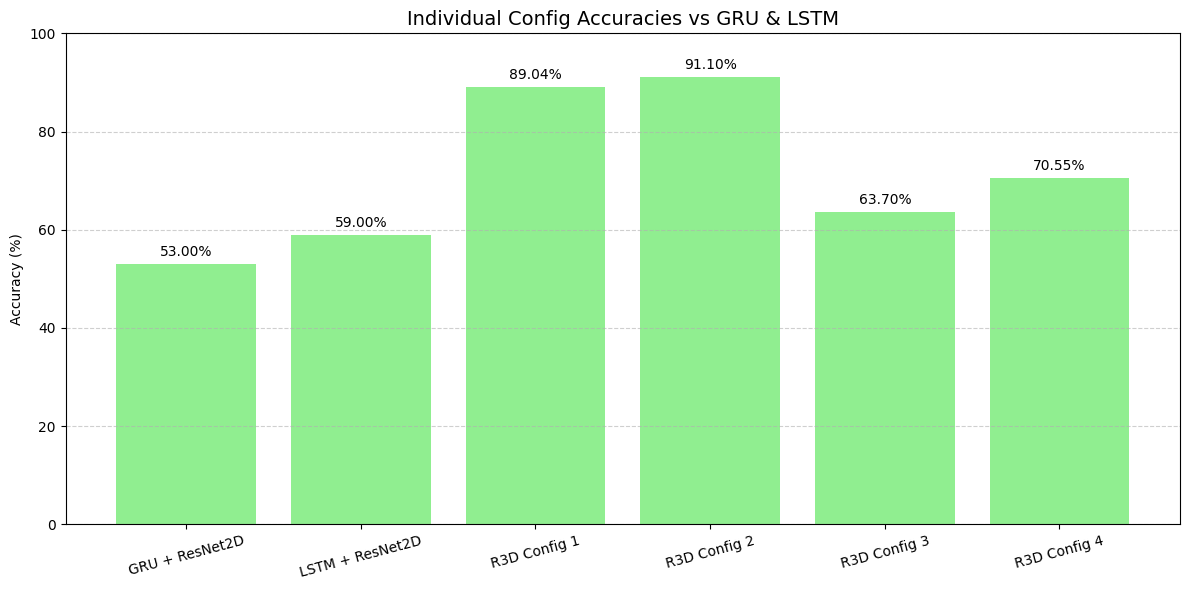

In [7]:
# Expanded comparison
model_names = ['GRU + ResNet2D', 'LSTM + ResNet2D', 'R3D Config 1', 'R3D Config 2', 'R3D Config 3', 'R3D Config 4']
accuracies = [gru_resnet2d * 100, lstm_resnet2d * 100] + [acc * 100 for acc in r3d_accuracies]

plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, accuracies, color='lightgreen')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{bar.get_height():.2f}%', ha='center', va='bottom')

plt.title("Individual Config Accuracies vs GRU & LSTM", fontsize=14)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


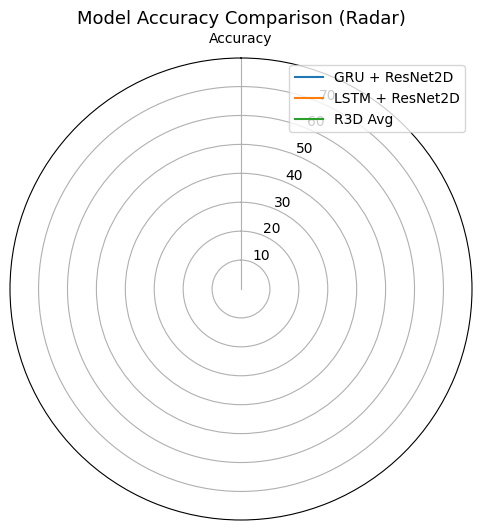

In [8]:
from math import pi

labels = ['Accuracy']
models = ['GRU + ResNet2D', 'LSTM + ResNet2D', 'R3D Avg']
data = [gru_percent, lstm_percent, r3d_percent]

angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
angles += angles[:1]  # Loop back to start

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for i, (name, val) in enumerate(zip(models, data)):
    values = [val] + [val]  # Close the circle
    ax.plot(angles, values, label=name)
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], labels)
plt.title("Model Accuracy Comparison (Radar)", size=13)
plt.legend(loc='upper right')
plt.show()


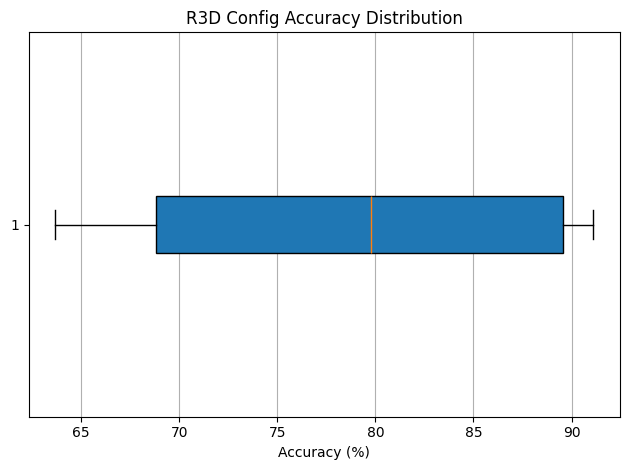

In [9]:
plt.boxplot([acc * 100 for acc in r3d_accuracies], vert=False, patch_artist=True)
plt.title("R3D Config Accuracy Distribution")
plt.xlabel("Accuracy (%)")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()
